<a href="https://github.com/ml-dafe/ml_mipt_dafe/tree/main/hw2/prototypical_omniglot_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Netwoks on the Omniglot dataset

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [1]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
!chcp 65001

Active code page: 65001


In [3]:
# Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


## Import data

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [4]:
# !wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

# !wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

import urllib.request

url_bg = "https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip"
url_eval = "https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip"

urllib.request.urlretrieve(url_bg, "images_background.zip")
urllib.request.urlretrieve(url_eval, "images_evaluation.zip")

KeyboardInterrupt: 

In [ ]:
# !unzip -qq images_background.zip
# !unzip -qq images_evaluation.zip
import zipfile

with zipfile.ZipFile('images_background.zip', 'r') as zip_ref:
    zip_ref.extractall('images_background')

with zipfile.ZipFile('images_evaluation.zip', 'r') as zip_ref:
    zip_ref.extractall('images_evaluation')

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [ ]:
import os
import numpy as np

def read_alphabets(alphabet_directory_path):
    datax = [] 
    datay = []  

    alphabet_name = os.path.basename(alphabet_directory_path)

    for character_name in os.listdir(alphabet_directory_path):
        character_path = os.path.join(alphabet_directory_path, character_name)

        for image_name in os.listdir(character_path):
            image_path = os.path.join(character_path, image_name)
            datax.append(image_path)
            datay.append(str(alphabet_name))

    return np.array(datax), np.array(datay)

In [5]:
def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    
    results = [read_alphabets(base_directory + '/' + directory ) for directory in os.listdir(base_directory)]    
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.concatenate([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [6]:
trainx, trainy = read_images('images_background/images_background')

In [7]:
testx, testy = read_images('images_evaluation/images_evaluation')

In [ ]:
print(trainx.shape, trainy.shape, testx.shape, testy.shape)

print(trainy[0])

(19280,) (19280,) (13180,) (13180,)
Alphabet_of_the_Magi


## Create samples

In [ ]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support + n_query)]
        sample.append([cv2.resize(cv2.imread(fname), (28, 28))
                                  for fname in sample_cls])
        
    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3)
    return {
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query,
        'classes': K  # добавляем реальные классы
    }

In [ ]:
def display_sample(sample):
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    
    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


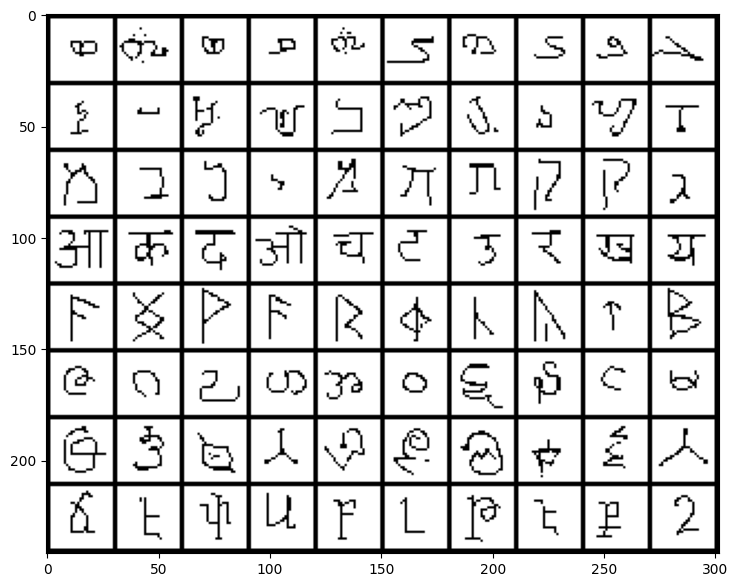

In [11]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [12]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [ ]:
class ProtoNetEncoder(nn.Module):
    def __init__(self, input_channels=3, hidden_channels=64):
        super(ProtoNetEncoder, self).__init__()
        
        # Каждый блок: Conv2d -> BatchNorm2d -> ReLU -> MaxPool2d(2x2)
        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
    def forward(self, sample):
        # sample: (n_way, n_classes, C, H, W)
        n_way, n_classes, c, h, w = sample.shape

        # в (n_way * n_classes, C, H, W)
        x = sample.view(n_way * n_classes, c, h, w)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        # Флэттим вектора признаков: (n_way * n_classes, 64)
        x = torch.flatten(x, start_dim=1)

        # Возвращаем в (n_way, n_classes, 64)
        x = x.view(n_way, n_classes, -1)

        return x


### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [ ]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, sample):
        x = sample['images']
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        device = next(self.parameters()).device
        x = x.to(device)

        # Получаем эмбеддинги
        emb = self.encoder(x)  # (n_way * (n_support + n_query), D)
        D = emb.size(-1)
        emb = emb.view(n_way, n_support + n_query, D)

        emb_support = emb[:, :n_support, :]  # (n_way, n_support, D)
        emb_query   = emb[:, n_support:, :]  # (n_way, n_query, D)

        # Вычисляем прототипы
        prototypes = emb_support.mean(1)  # (n_way, D)

        # Расстояния между каждым запросом и всеми прототипами
        emb_query = emb_query.contiguous().view(n_way * n_query, D)  # (n_way*n_query, D)
        dists = torch.cdist(emb_query, prototypes)  # (n_way*n_query, n_way)

        log_p_y = F.log_softmax(-dists, dim=1)  # минус расстояния → ближе = больше лог-проб.

        y_gt = torch.arange(n_way).unsqueeze(1).expand(n_way, n_query).reshape(-1).to(device)  # (n_way*n_query)

        loss_val = F.nll_loss(log_p_y, y_gt)
        y_hat = log_p_y.argmax(1)
        acc_val = (y_hat == y_gt).float().mean()

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat
        }

In [ ]:
def load_protonet_conv(x_dim, hid_dim, z_dim):

    encoder = ProtoNetEncoder() # your code
    return ProtoNet(encoder)

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [ ]:
os.environ['WANDB_MODE'] = 'offline'
import wandb


def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0  

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    device = next(model.parameters()).device 

    wandb.watch(model, log="all", log_freq=100)  # градиенты и параметры

    for epoch in range(max_epoch):
        running_loss, running_acc = 0.0, 0.0

        prog_bar = tnrange(epoch_size, desc=f"Epoch {epoch+1}")
        for _ in prog_bar:
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            sample["images"] = sample["images"].to(device)

            optimizer.zero_grad()
            loss, out = model.set_forward_loss(sample)
            loss.backward()
            optimizer.step()

            running_loss += out["loss"]
            running_acc  += out["acc"]

            prog_bar.set_postfix(loss=f"{out['loss']:.4f}")

        epoch_loss = running_loss / epoch_size
        epoch_acc  = running_acc  / epoch_size
        lr_now = scheduler.get_last_lr()[0]

        print(f"Epoch {epoch+1:02d} -- Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}  LR: {lr_now:.6f}")

        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss,
            "accuracy": epoch_acc,
            "lr": lr_now,
        })

        scheduler.step()

    # Сохраняем финальную модель
    torch.save(model.state_dict())
    print(f" Model saved")

    wandb.save()

In [ ]:
model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 30
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 2
epoch_size = 2000

Число уникальных классов в train_y: 30


In [ ]:
%%time

wandb.init(project="protonet", config={
    "n_way": n_way,
    "n_support": n_support,
    "n_query": n_query,
    "max_epoch": max_epoch,
    "epoch_size": epoch_size,
    "initial_lr": optimizer,
})

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


accuracy,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
lr,█▄▂▁▁
accuracy,0.99961
epoch,5
loss,0.01311
lr,6e-05


Epoch 1:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 -- Loss: 0.8868  Acc: 0.7476  LR: 0.001000


Epoch 2:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 -- Loss: 0.1409  Acc: 0.9715  LR: 0.000500


TypeError: save() missing 1 required positional argument: 'f'

In [ ]:
torch.save(model.state_dict(), "model.pt")
print("Model saved")

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Model saved


True

## Test

In [ ]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']
        
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [103]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

In [104]:
test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 1.3245 Acc: 0.5316


## Test on specific example

In [ ]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



In [ ]:
def visualize_predictions(sample, preds, true_labels_indices):
    images = sample['images'].cpu().numpy()  # (n_way, n_query, H, W, C)
    n_way = sample['n_way']
    n_query = sample['n_query']
    class_labels = sample['classes']

   
    images_flat = images.reshape(-1, images.shape[2], images.shape[3], images.shape[4])  # (n_way*n_query, H, W, C)

    pred_names = [class_labels[i] for i in preds]
    true_names = [class_labels[i] for i in true_labels_indices]

    cols = n_query
    rows = n_way

    plt.figure(figsize=(cols*3, rows*3))
    for idx in range(len(images_flat)):
        plt.subplot(rows, cols, idx + 1)
        img = images_flat[idx]

        img = np.clip(img, 0, 1)  

        if img.shape[-1] == 1: 
            img = img.squeeze(-1)
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.axis('off')
        plt.title(f"P: {pred_names[idx]}\nT: {true_names[idx]}", fontsize=12)
    plt.tight_layout()
    plt.show()


In [ ]:
model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
)

model.load_state_dict(torch.load("model.pt"))
model.eval() 
print('')

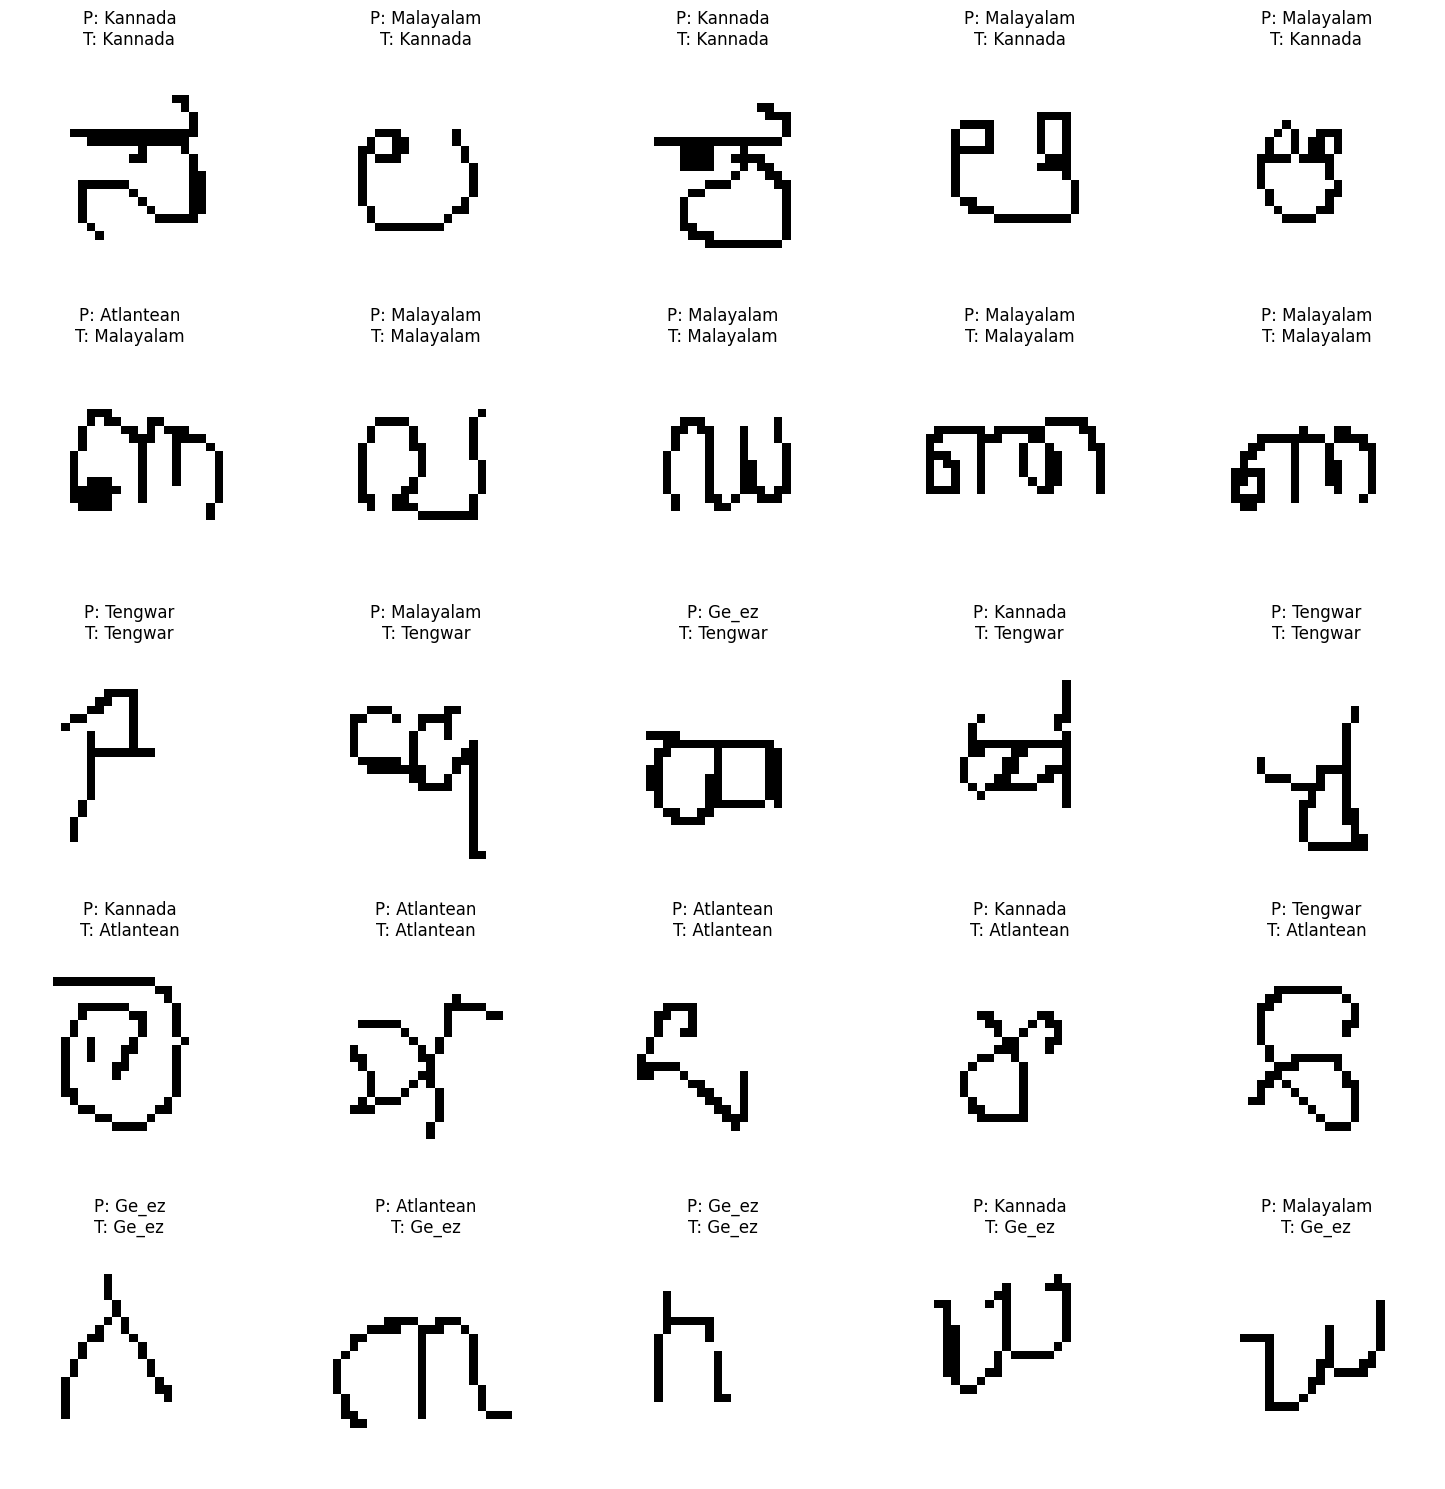

In [ ]:
sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
query_images = sample['images'][:, n_support:, :, :, :]  # (n_way, n_query, C, H, W)
query_images = query_images.permute(0, 1, 3, 4, 2)  # (n_way, n_query, H, W, C)
sample_query = {
    'images': query_images,
    'n_way': n_way,
    'n_support': 0,
    'n_query': n_query,
    'classes': sample['classes']
}

with torch.no_grad():
    loss, out = model.set_forward_loss(sample)
    logits = out['y_hat']
    preds = logits.cpu().numpy()

true_query_indices = []
for i in range(n_way):
    true_query_indices.extend([i] * n_query)

# preds должны быть длиной n_way * n_query
visualize_predictions(sample_query, preds, true_query_indices)

# Задание 6: Downstream task

## Задание 6.1
Ваша задача обучить заданную вами модель CNN методом SimCLR для набора данных CIFAR10, а затем использовать обученный энкодер для решения задачи классификации.

**Примечание:**
- В качестве базового энкодера можете использовать модель из семинара выше (```resnet18```) или определить свою сеть. **Рекомендуется** использовать уже предобученные сети из [torch zoo](https://pytorch.org/vision/stable/models.html).
- В качестве обучающего множества для задачи классификации воспользуйетсь ```X_test```, ```y_test```, которые были определены в самом начале ноутбука. Создайте обучающую и валидационную выборку.
- В новой CNN для задачи классификации требуется обучить только полносвязные слои после энкодера. Для этого вам потребуется "заморозить" веса энкодера и не учить их. Сделать это можно с помощью команды: 
```python
for p in encoder.parameters():
    p.requires_grad = False  
```
- Процесс обучения модели можно взять из предыдущего семинара

## Задание 6.2

Сравните полученный результат обучения c и без использования метода SimCLR.

In [107]:
!wandb sync "D:/05_Attention/08_Self_Supervision/homework/wandb/offline-run-*"


Find logs at: d:\05_Attention\08_Self_Supervision\homework\wandb\debug-cli.Vladlen.log
Syncing: https://wandb.ai/statieva-ad-mipt/protonet/runs/e1epqs22 ... done.
Syncing: https://wandb.ai/statieva-ad-mipt/protonet/runs/xhfizwph ... done.


wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.


Find logs at: d:\05_Attention\08_Self_Supervision\homework\wandb\debug-cli.Vladlen.log

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.



Syncing: https://wandb.ai/statieva-ad-mipt/protonet/runs/e1epqs22 ... done.
Syncing: https://wandb.ai/statieva-ad-mipt/protonet/runs/xhfizwph ... done.
